<a href="https://colab.research.google.com/github/OLaprevote/experiment-utilities/blob/main/plot_cd_tmelt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot Thermal unfolding followed by CD

This colab notebook is intended to plot thermal unfolding followed by CD from txt files as formatted by a Jasco J-710 machine.

In [1]:
#@title Upload files { vertical-output: true }
#@markdown Click on the **play** ▶️ button on the left, then on **Choose files** bellow to upload all your files.
#@markdown 
#@markdown You can select multiple files to upload by clicking on them while pressing Ctrl.

import matplotlib.pyplot as plt
from pathlib import Path
try:
    from google.colab import files
    is_colab = True
except ImportError:
    is_colab = False
    #TODO
    raise Exception('This notebook is currently only supported on Google Colab.'
                    ' To port it to a local notebook one needs to replace google.colab'
                    " files upload by the ipython widget upload. Trivial, but I "
                    " didn't feel like doing then testing it.")

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import constants
import seaborn as sns


# Plot parameters
sns.set_theme(style='ticks')
#sns.set_context('talk')

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.latex.preamble'] = r'\usepackage{subdepth} \usepackage{amsmath}'
plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
#plt.rcParams['axes.labelsize'] = 16
#plt.rcParams['axes.titlesize'] = 16
#plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 3

# Functions for fitting Tmelt
# See Robust and convenient analysis of protein thermal and chemical stability
# Niklasson et al. 2015. https://doi.org/10.1002%2Fpro.2809
def equilibrium_constant(temperature, denaturation_midpoint, delta_hm):
    r_kcal = constants.gas_constant /1000  # kJ/K/mol
    k = np.exp(-delta_hm/r_kcal * (1/denaturation_midpoint - 1/temperature))
    return k

def tmelt_law(temperature, an, bn, ad, bd, denaturation_midpoint, delta_hm):
    fraction_native = lambda k: 1/(1+k)
    fraction_denatur = lambda k: k/(1+k)
    
    temp_kelvin = constants.zero_Celsius + temperature
    k = equilibrium_constant(temp_kelvin, denaturation_midpoint, delta_hm)
    return (fraction_native(k) * (an + bn * temperature)
            + fraction_denatur(k) * (ad + bd * temperature))


def df_tmelt(file_path: Path):
    """Create dataframe from a Tmelt txt file
    
    Parameters
    ----------
    file_path: Path
        Path of the file

    Returns
    -------
    df_tmelt: pandas.DataFrame
        DataFrame containing all Tmelt informations
    """
    # Read file
    df_tmelt = pd.read_csv(file_path, sep='\s+',
                          names = ['Temperature (°C)', 'CD (mdeg)', 'HT (V)'],
                          skiprows=19
                         )    
    return df_tmelt


def normalize_fraction_denatur(df, popt):
    """Compute fraction of denatured protein

    Parameters
    ----------
    df: pandas.DataFrame
        Tmelt dataframe
    popt: 1D numpy.array
        As returned by scipy.optimize.curve_fit
    
    Returns
    -------
    fraction_denatur: pandas.Series
    """
    an, bn, ad, bd = popt[:4]
    fraction_denatur = np.zeros(df.shape[0])
    for k in range(df.shape[0]):
        fraction_denatur[k] = ((df['CD (mdeg)'][k] - (an + bn * df['Temperature (°C)'][k]))
                 / (ad + bd * df['Temperature (°C)'][k]
                    - (an + bn * df['Temperature (°C)'][k])
                   )
                )
    return fraction_denatur


# Get files
if is_colab:
    uploaded = files.upload()
    fpath_list = [Path(fn) for fn in uploaded.keys()]

Saving 2022-05-13_tmelt_TrpR#001.txt to 2022-05-13_tmelt_TrpR#001.txt
Saving 2022-05-13_tmelt_TrpR-WT-R1#001.txt to 2022-05-13_tmelt_TrpR-WT-R1#001.txt


± standard deviation
TrpR denaturation midpoint: Tm = 90.53 ± 1.14°C
TrpR enthalpy change at Tm: ΔHm = 268.13 ± 6.58 kJ/mol

TrpR WT-R1 denaturation midpoint: Tm = 76.68 ± 0.63°C
TrpR WT-R1 enthalpy change at Tm: ΔHm = 149.88 ± 4.46 kJ/mol



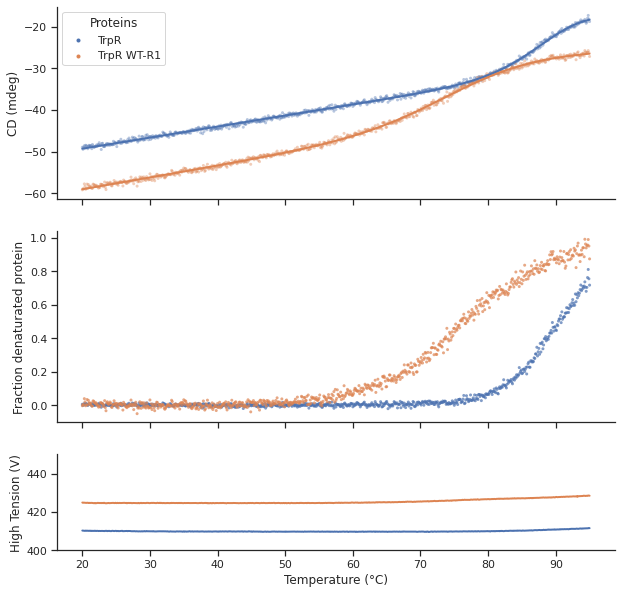

In [6]:
#@title Fill labels and show graph { vertical-output: true }
#@markdown Enter the labels you'd want for each file in upload order, separated by a comma

labels = "TrpR, TrpR WT-R1" #@param {type:"string"}
label_list = labels.split(', ')

df_tm = pd.DataFrame()
print('± standard deviation')
for label, fpath in zip(label_list, fpath_list):
    df = df_tmelt(Path(fpath))

    # Fit options and their covariance    
    popt, pcov = curve_fit(f=tmelt_law,
                    xdata=list(df['Temperature (°C)']),
                    ydata=list(df['CD (mdeg)']),
                    p0=[-100, 0.1, -30, 0.1, 340, -300])
    # Standard error of each options
    perr = np.sqrt(np.diag(pcov))

    df['Fraction denaturated protein'] = normalize_fraction_denatur(df, popt)
    df['Fit'] = tmelt_law(df['Temperature (°C)'], *popt)
    df['Proteins'] = label
    df_tm = df_tm.append(df, ignore_index=True)

    print(f'{label} denaturation midpoint: Tm = {popt[4]-constants.zero_Celsius:.2f}'
          f' ± {perr[4]:.2f}°C\n'
          f'{label} enthalpy change at Tm: ΔHm = {np.abs(popt[5]):.2f}'
          f' ± {perr[5]:.2f} kJ/mol\n')


# Plot
fig, ax = plt.subplots(3, figsize=(10, 10), sharex=True,
                      gridspec_kw={'height_ratios': [2, 2, 1]})
params = dict(x='Temperature (°C)', data=df_tm, hue='Proteins')
# CD raw data
sns.scatterplot(**params, y='CD (mdeg)', ax=ax[0], alpha=0.4, linewidth=0)
sns.lineplot(**params, y='Fit', ax=ax[0], legend=False)

# CD fit
sns.scatterplot(**params, y='Fraction denaturated protein', ax=ax[1],
               alpha=0.7, legend=False, linewidth=0)

# Voltage
sns.lineplot(**params, y='HT (V)', ax=ax[2], legend=False)
ax[2].set_ylim(bottom=400, top=450)
ax[2].set_ylabel('High Tension (V)')

sns.despine()

In [ ]:
#@title Download graph
format = 'pdf' #@param ['emf', 'eps', 'pdf', 'png', 'ps', 'raw', 'rgba', 'svg', 'svgz']
fn = f'tmelt.{format}'
fig.savefig(fn)
files.download(fn)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Methods

Spectra are normalized to the fraction of denaturated protein ($f_d$), as described in [Kordes et al. 2021](https://doi.org/10.1002/PRO.4249):

$f_d = \frac{y_{obs} - (a_n + b_nT)}{(a_d + b_dT) - (a_n + b_nT)}$

with $y_{obs}$ the observed CD signal at a given temperature, and $(a_n + b_nT)$ and $(a_d + b_dT)$ the linear fitting equations of the native and denaturated proteins, respectively.

Signal is fit using [non-linear least-square](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). The signal function depends on the parameters $a_n$, $b_n$, $a_d$, $b_d$, the denaturation midpoint $T_m$ and $ΔH_m$ the change in enthalpy at $T_m$. The signal function follows the equation:

$y(T) = f_n(a_n + b_nT) + f_d(a_d + b_dT)$

With $y(T)$ the CD signal depending on the temperature. The fractions of native and denaturated proteins are computed as $f_n = \frac{1}{1 + K}$ and $f_d = \frac{K}{1 + K}$, respectively, where the equilibrium constant $K$ follows:

$K = e^{-\frac{ΔH_m}{R}(\frac{1}{T_m}-\frac{1}{T})+\frac{ΔC_p}{R}(\frac{T_m}{T} - 1 + ln(\frac{T}{T_m}))}$

With $R$ the gas constant and $ΔC_p$ the difference in heat capacity, which is assumed to be 0 when fitting the curve. ([Niklasson et al. 2015](https://doi.org/10.1002/pro.2809))

⚠️ **These calculations don't take into account an intermediary state.** 

⚠️ **The confidence interval displayed is only the standard deviation, i.e. the square root of the parameter variance as given by scipy.optimize.curve_fit.**


## Code

Feel free to modify the code until the graphs are as beautiful as wished.

If you can spare some time and encounter a bug of any kind or wish for some additions/improvements, please write an issue on the GitHub page. If you code the improvement yourself: please fork the project, modify it and make a Pull request 😉